<a href="https://colab.research.google.com/github/juliafsuzuki/01-workplace-wellbeing/blob/main/JS_SimpleLinearRegressionModels_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple Linear Regression Models** | Input: Neural Activity - Output: Running Speed

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold


In [17]:
# import pytorch library
import torch

In [96]:
# @title NMA Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [97]:
# @title NMA Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [98]:
# @title NMA Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [99]:
# @title Shape of each data

print('neural activity:   ', dat['sresp'].shape)
print('running speed:  ', dat['run'].shape)
print('pupil area:  ', dat['pupilArea'].shape)
print('face movement :   ',dat['beh_svd_time'].shape)

# print('stat:  ', dat['stat'].shape)
# print('pupil xy position:  ', dat['pupilCOM'].shape)


neural activity:    (11983, 7018)
running speed:   (7018, 1)
pupil area:   (7018, 1)
face movement :    (7018, 1000)


In [100]:
# @title Input and Output of the Model

neural_activity = dat['sresp']    # Input
run_speed = dat['run']            # Output
pupil_area = dat['pupilArea']     # Output
face_svd = dat['beh_svd_time']    # Output

print('neural activity:   ', neural_activity.shape)
print('running speed:  ', run_speed.shape)
print('pupil area:  ', pupil_area.shape)
print('face movement :   ', face_svd.shape)


neural activity:    (11983, 7018)
running speed:   (7018, 1)
pupil area:   (7018, 1)
face movement :    (7018, 1000)


In [101]:
# manipulate data
neural_activity = np.transpose(neural_activity)
runspeed = run_speed.squeeze()
pupilarea = pupil_area.squeeze()
facesvd = face_svd[:,:100]

print('neural activity:  ', neural_activity.shape)
print('run speed:  ',runspeed.shape)
print('pupil area:  ',pupilarea.shape)
print('face movement:  ',facesvd.shape)

neural activity:   (7018, 11983)
run speed:   (7018,)
pupil area:   (7018,)
face movement:   (7018, 100)


In [102]:
# @title Dimension Reduction of the Input using PCA
pca_model = PCA(n_components=500)
reduced = pca_model.fit_transform(neural_activity)
component = pca_model.components_
neural_activity = reduced
print(neural_activity.shape)
# print(component.shape)

(7018, 500)


In [103]:
print('neural activity:  ', neural_activity.shape)
print('run speed:  ',runspeed.shape)
print('pupil area:  ',pupilarea.shape)
print('face movement:  ',facesvd.shape)

neural activity:   (7018, 500)
run speed:   (7018,)
pupil area:   (7018,)
face movement:   (7018, 100)


# **Scenario 01: Pytorch Regression Model**: neural activity -> running speed

Reference: "https://machinelearningmastery.com/building-a-regression-model-in-pytorch/"

In [104]:
X = neural_activity
y = runspeed

In [105]:
print("X: neural activity - type: {}".format(type(X))) # type
print("X: neural activity - shape: {}".format(np.shape(X))) # shape
print("y: runnning speed - type: {}".format(type(y))) # type
print("y: running speed - shape: {}".format(np.shape(y))) # shape

X: neural activity - type: <class 'numpy.ndarray'>
X: neural activity - shape: (7018, 500)
y: runnning speed - type: <class 'numpy.ndarray'>
y: running speed - shape: (7018,)


In [106]:
# import variable from pytorch library
from torch.autograd import Variable

X_tensor = Variable(torch.from_numpy(X))
y_tensor = Variable(torch.from_numpy(y))

In [107]:
print("X: neural activity - type: {}".format(type(X_tensor))) # type
print("X: neural activity - shape: {}".format(np.shape(X_tensor))) # shape
print("y: runnning speed - type: {}".format(type(y_tensor))) # type
print("y: running speed - shape: {}".format(np.shape(y_tensor))) # shape

X: neural activity - type: <class 'torch.Tensor'>
X: neural activity - shape: torch.Size([7018, 500])
y: runnning speed - type: <class 'torch.Tensor'>
y: running speed - shape: torch.Size([7018])


In [108]:
print(X_tensor)

tensor([[ -814.7930,   770.0335,   163.2014,  ...,   -80.1242,  -240.6386,
            61.4455],
        [  843.1537,  1967.0154,   200.5268,  ...,   -75.9065,   -79.1066,
           165.9064],
        [  694.7301,  1296.5499,   398.1853,  ...,   -96.7793,    20.2814,
          -229.6613],
        ...,
        [-1712.7102,  1082.9021,  -666.5040,  ...,    64.6544,    94.5293,
            22.4671],
        [-1283.1820,  2531.2021,   176.6462,  ...,  -247.6459,  -336.7545,
            53.2713],
        [ 1350.2249,  2772.8589,    73.7640,  ...,    -8.1270,    93.0439,
           -14.4022]])


In [109]:
print(y_tensor)

tensor([0.0436, 5.6885, 9.1309,  ..., 3.7686, 9.7930, 7.6647],
       dtype=torch.float64)


In [110]:
# copied from NMA DL Program, "W1D2_Tutorial1"
# source: https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W1D2_LinearDeepLearning/student/W1D2_Tutorial1.ipynb#scrollTo=R36u3ImTA7fQ

import torch.nn as nn

class WideNet(nn.Module):
  """
   A Wide neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(1, n_cells) + nn.Tanh(), # Fully connected layer with tanh activation
        nn.Linear(n_cells, 1) # Final fully connected layer
    )
  """

  def __init__(self):
    """
    Initializing the parameters of WideNet

    Args:
      None

    Returns:
      Nothing
    """
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(500, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )

  def forward(self, x):
    """
    Forward pass of WideNet

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """
    return self.layers(x)

In [120]:
# Creating an instance
model = WideNet()

In [121]:
# define a mse loss function
loss_fn = nn.MSELoss()

# define an optimizer, Stochstic Gradient Descent optimizer
lr = 0.003  # Learning rate
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [122]:
print(X_tensor.type)
print(y_tensor.type)


<built-in method type of Tensor object at 0x7a5e3e3930b0>
<built-in method type of Tensor object at 0x7a5e3e393060>


In [123]:
# define the training process in PyTorch
# let's perform one training iteration

# X_tensor.double()
# y_tensor.double()

# X_tensor.float()
# y_tensor.float()

# step 1: reset all gradients to zero
sgd_optimizer.zero_grad()

# step 2: forward pass (Compute the output of the model on the features (inputs))
prediction = model(X_tensor)

# step 3: compute the loss
loss = loss_fn(prediction, y_tensor)
print("loss - type: {}".format(type(loss))) # type
print(f'loss: {loss.item()}')


# step 4: perform backpropagation to build the graph and compute the gradients
# loss.backward()
# troubleshoot! Why this above code gives me an error?

# step 5: optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7018])) that is different to the input size (torch.Size([7018, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss - type: <class 'torch.Tensor'>
loss: 385.83914702520747


In [126]:
# run the training process in a loop

def train(features, labels, model, loss_fn, sgd_optimizer, n_epochs):
  """
  Training function

  Args:
    features: torch.Tensor
      Features (input) with shape torch.Size([n_samples, 1])
    labels: torch.Tensor
      Labels (targets) with shape torch.Size([n_samples, 1])
    model: torch nn.Module
      The neural network
    loss_fn: function
      Loss function
    sgd_optimizer: function
      SGD_Optimizer
    n_epochs: int
      Number of training iterations

  Returns:
    loss_record: list
      Record (evolution) of training losses
  """
  loss_record = []  # Keeping recods of loss

  for i in range(n_epochs):
    #################################################
    ## Implement the missing parts of the training loop
    # Complete the function and remove or comment the line below
    # raise NotImplementedError("Training loop `train`")
    #################################################
    ...  # Set gradients to 0
    sgd_optimizer.zero_grad()  # Set gradients to 0
    predictions = model(features)  # Compute model prediction (output)
    loss = loss_fn(predictions, labels)  # Compute the loss
    loss.backward()  # Compute gradients (backward pass)
    sgd_optimizer.step()  # Update parameters (optimizer takes a step)

    loss_record.append(loss.item())
  return loss_record

In [117]:
# @title Plotting functions

from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()

In [130]:
epochs = 1847 # Cauchy, Exercices d'analyse et de physique mathematique (1847)

losses = train(X_tensor, y_tensor, wide_net, loss_fn, sgd_optimizer, epochs)
ex3_plot(wide_net, X_tensor, y_tensor, epochs, losses)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7018])) that is different to the input size (torch.Size([7018, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [131]:
# copied Golnaz's codes

import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# train-test split of the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.7, shuffle=False)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            sgd_optimizer.zero_grad()
            loss.backward()
            # update weights
            sgd_optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<ipython-input-131-cb1f10fdece9>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
<ipython-input-131-cb1f10fdece9>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([4912, 500])
torch.Size([4912])
torch.Size([2106, 500])
torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<All keys matched successfully>

MSE: 129.11
RMSE: 11.36


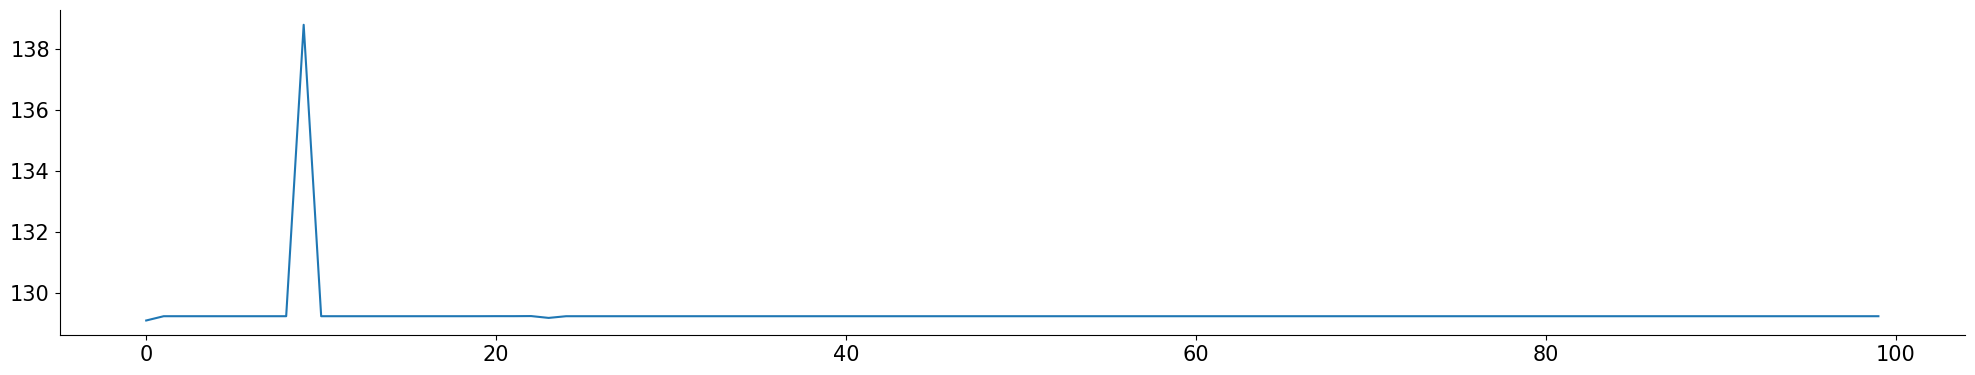

In [128]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

torch.Size([2106, 1])
torch.Size([2106])


IndexError: ignored

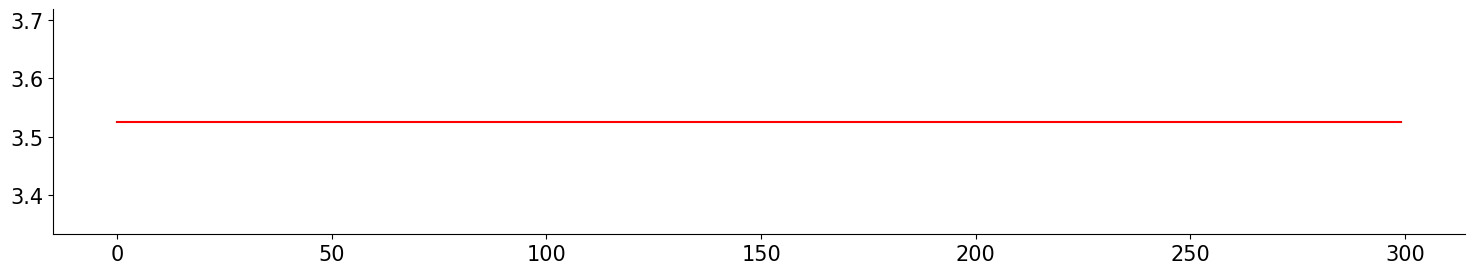

In [129]:
# @title Results of linear decoding of face SVD
print(y_pred.shape)
print(y_test.shape)
plt.figure(figsize=(15,3))
svdnum = 0
plt.plot(y_pred[0:300, svdnum].detach().numpy(), color = 'r', label = "model output")
plt.plot(y_test[0:300, svdnum].detach().numpy(), color = 'g', label = "desired output")
plt.legend()
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.title('Face SVD')

plt.figure(figsize=(6,4))
err = y_pred.detach().numpy().squeeze()[:,svdnum] - y_test.detach().numpy()[:,svdnum]
plt.scatter(y_pred.detach().numpy()[:,svdnum], y_test.detach().numpy()[:,svdnum], c=err)
plt.xlabel("model output")
plt.ylabel("desired output")
plt.colorbar()
plt.xlim((0, np.max([y_pred.detach().numpy().squeeze()[:,svdnum], y_test.detach().numpy()[:,svdnum]])))
plt.ylim((0, np.max([y_pred.detach().numpy().squeeze()[:,svdnum], y_test.detach().numpy()[:,svdnum]])))


In [ ]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(500, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, num_of_svd)
)